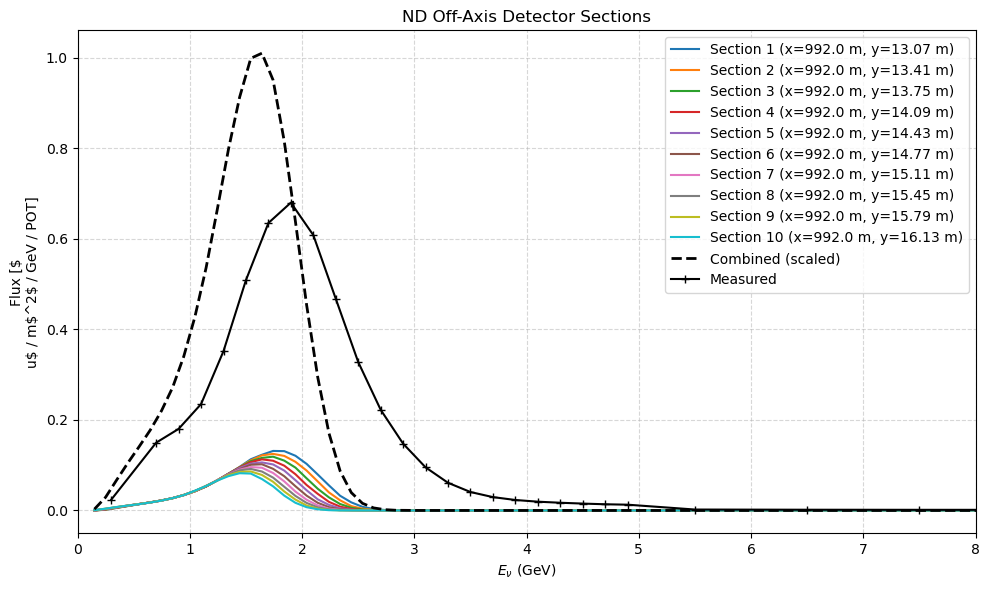

[ 0.14975  0.24925  0.34875  0.44825  0.54775  0.64725  0.74675  0.84625
  0.94575  1.04525  1.14475  1.24425  1.34375  1.44325  1.54275  1.64225
  1.74175  1.84125  1.94075  2.04025  2.13975  2.23925  2.33875  2.43825
  2.53775  2.63725  2.73675  2.83625  2.93575  3.03525  3.13475  3.23425
  3.33375  3.43325  3.53275  3.63225  3.73175  3.83125  3.93075  4.03025
  4.12975  4.22925  4.32875  4.42825  4.52775  4.62725  4.72675  4.82625
  4.92575  5.02525  5.12475  5.22425  5.32375  5.42325  5.52275  5.62225
  5.72175  5.82125  5.92075  6.02025  6.11975  6.21925  6.31875  6.41825
  6.51775  6.61725  6.71675  6.81625  6.91575  7.01525  7.11475  7.21425
  7.31375  7.41325  7.51275  7.61225  7.71175  7.81125  7.91075  8.01025
  8.10975  8.20925  8.30875  8.40825  8.50775  8.60725  8.70675  8.80625
  8.90575  9.00525  9.10475  9.20425  9.30375  9.40325  9.50275  9.60225
  9.70175  9.80125  9.90075 10.00025 10.09975 10.19925 10.29875 10.39825
 10.49775 10.59725 10.69675 10.79625 10.89575 10.99

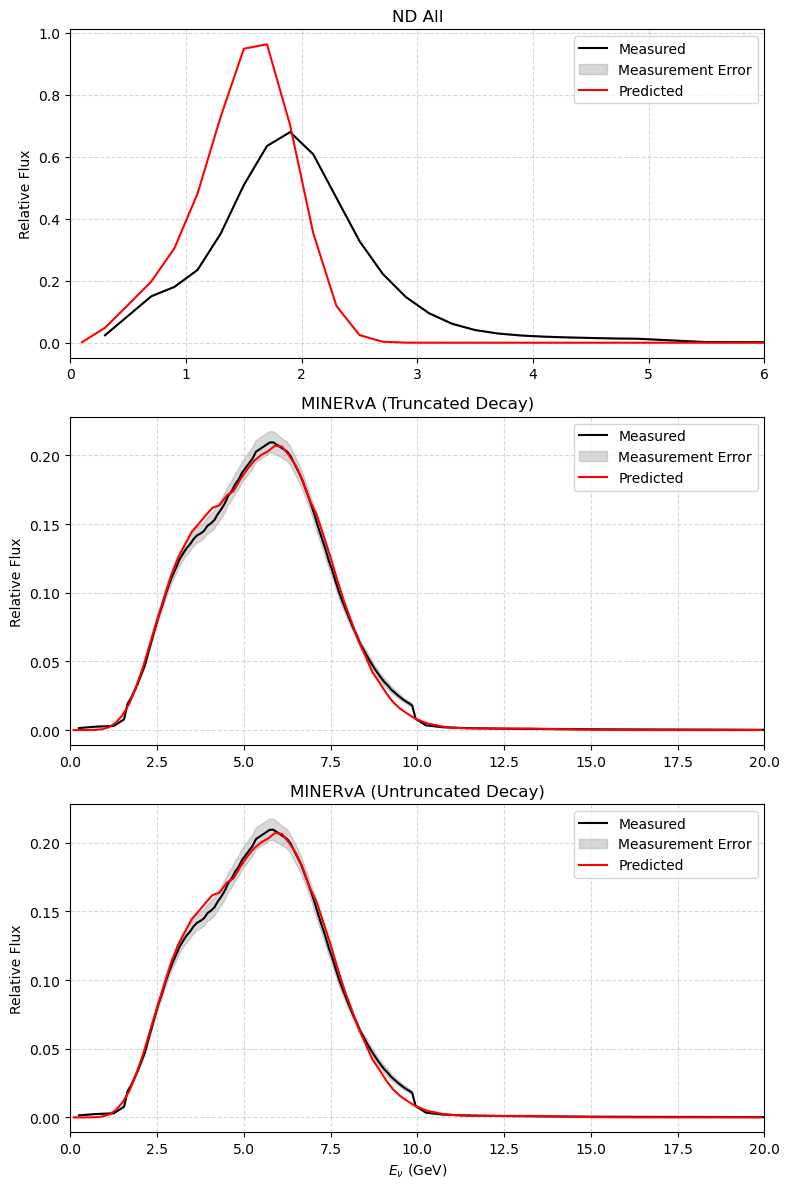

ValueError: x and y must have same first dimension, but have shapes (128,) and (10, 1500, 700)

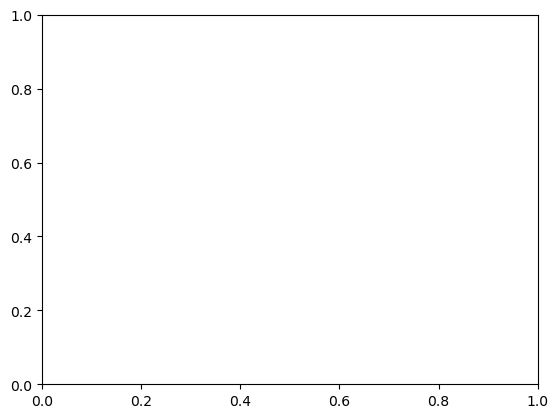

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error


# Physical constants

E_STAR = 29.8   # Conversion factor
M_PI = 139.6    # MeV/c^2
TAU_PI = 26.03  # ns (pion rest-frame lifetime)

# ---------------------------
# Utility functions
# ---------------------------

def compute_bin_edges(centers: np.ndarray) -> np.ndarray:
    """
    Compute histogram edges from bin centers.
    """
    widths = np.diff(centers)
    edges = np.empty(len(centers) + 1)
    edges[1:-1] = (centers[:-1] + centers[1:]) / 2
    edges[0]     = centers[0] - widths[0] / 2
    edges[-1]    = centers[-1] + widths[-1] / 2
    return edges


def sample_pion_energy(params: tuple, n_samples: int, seed: int = 42) -> np.ndarray:
    """
    Sample pion energies from a 3-component mixture (gamma + two normals).
    params = (w1_raw, w2_raw, a1, scale1, mu2, sigma2, mu3, sigma3)
    """
    rng = np.random.default_rng(seed)
    w1_raw, w2_raw, a1, scale1, mu2, sigma2, mu3, sigma3 = params
    w1 = w1_raw
    w2 = w2_raw * (1 - w1)
    w3 = 1 - w1 - w2
    n1 = int(w1 * n_samples)
    n2 = int(w2 * n_samples)
    n3 = n_samples - n1 - n2
    s1 = gamma.rvs(a=a1, scale=scale1, size=n1, random_state=rng)
    s2 = norm.rvs(loc=mu2, scale=sigma2, size=n2, random_state=rng)
    s3 = norm.rvs(loc=mu3, scale=sigma3, size=n3, random_state=rng)
    return np.concatenate([s1, s2, s3])


def compute_lab_neutrino_energy(e_pi: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """
    Vectorized lab-frame neutrino energy from pion energies and angles.
    """
    gamma_factor = e_pi * 1000 / M_PI
    return (0.002 * E_STAR * gamma_factor) / (1 + (gamma_factor * theta)**2)


def build_pion_slices(params: tuple,
                       scan_min: float,
                       scan_max: float,
                       slice_width: float) -> np.ndarray:
    """
    Build pion energy slices & weights via mixture CDF differences.
    Returns array of shape (n_s,3): [E_mid, gamma, weight].
    """
    w1_raw, w2_raw, a1, scale1, mu2, sigma2, mu3, sigma3 = params
    w1 = w1_raw
    w2 = w2_raw * (1 - w1)
    w3 = 1 - w1 - w2
    def mixture_cdf(x):
        return (w1 * gamma.cdf(x, a=a1, scale=scale1)
                + w2 * norm.cdf(x, loc=mu2, scale=sigma2)
                + w3 * norm.cdf(x, loc=mu3, scale=sigma3))
    edges = np.arange(scan_min, scan_max + slice_width, slice_width)
    mids = 0.5 * (edges[:-1] + edges[1:])
    weights = mixture_cdf(edges[1:]) - mixture_cdf(edges[:-1])
    gamma_vals = mids * 1000 / M_PI
    #print(np.sum(weights))
    return np.vstack([mids, gamma_vals, weights]).T


def compute_decay_population(pion_slices: np.ndarray, time_steps: np.ndarray) -> np.ndarray:
    """
    Vectorized decay population over time for each slice.
    Returns decay_pop: shape (n_slices, n_times).
    """
    gamma_vals = pion_slices[:,1]       # (n_slices,)
    weights    = pion_slices[:,2]       # (n_slices,)
    t = time_steps[np.newaxis, :]       # (1, n_times)
    G = gamma_vals[:, np.newaxis]       # (n_slices, 1)
    dt = time_steps[1] - time_steps[0]
    exp_t    = np.exp(-t / (G * TAU_PI))
    exp_t_dt = np.exp(-(t - dt) / (G * TAU_PI))
    decay_prob = np.empty_like(exp_t)
    decay_prob[:,0] = 1 - exp_t[:,0]
    decay_prob[:,1:] = exp_t_dt[:,1:] - exp_t[:,1:]
    return decay_prob * weights[:, np.newaxis]


def rebin_time_to_distance(events: np.ndarray, speeds: np.ndarray,
                            dt: float, dd: float):
    """
    Rebin events from time bins to distance bins via CDF interpolation.
    Returns (dist_events, max_distance, n_bins).
    """
    # ensure valid speeds
    speeds = np.clip(speeds, 0, 0.3)
    n_s, n_t = events.shape
    d_mid = speeds[:, None] * ((np.arange(n_t)[None,:] + 0.5) * dt)
    max_d = np.nanmax(d_mid)
    dist_edges = np.arange(0, max_d + dd, dd)
    n_bins = len(dist_edges) - 1
    dist_events = np.zeros((n_s, n_bins))
    for i in range(n_s):
        cum = np.concatenate(([0], np.cumsum(events[i])))
        d_vals = np.concatenate(([0], d_mid[i]))
        F = np.interp(dist_edges, d_vals, cum, left=0, right=cum[-1])
        dist_events[i] = np.diff(F)
    return dist_events, max_d, n_bins

def compute_flux_matrix_onaxis(pion_slices, dist_events, l_adj, dd):
    """
    Simplified flux matrix for on-axis detector (no solid angle correction).
    """
    n_s, n_d = dist_events.shape
    beam_d = l_adj - np.arange(n_d) * dd
    Thetas = np.zeros((1, n_d))  # On-axis ⇒ θ = 0
    E_pi = pion_slices[:, 0]
    G = E_pi * 1000 / M_PI
    G3 = G[None, :, None]
    Th3 = Thetas[:, None, :]
    nu_e_all = (0.002 * E_STAR * G3) / (1 + (G3 * Th3)**2)
    flux_all = dist_events[None, :, :] * nu_e_all
    return nu_e_all, flux_all

def compute_flux_matrix(dets: np.ndarray,
                        pion_slices: np.ndarray,
                        dist_events: np.ndarray,
                        dd: float,
                        det_width: float = 4.0,
                        det_height: float = 4.0) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    Compute neutrino energies & flux for detectors at arbitrary (x, y) positions.
    Returns (nu_e_all, flux_all, solid_angle) of shape (n_det, n_slices, n_dist).
    """
    n_s, n_d = dist_events.shape
    x_dets = dets[:, 0]  # (n_det,)
    y_dets = dets[:, 1]  # (n_det,)
    n_det = len(x_dets)

    # Distance from decay point to detector along beam axis
    beam_d = x_dets[:, None] - np.arange(n_d) * dd  # shape (n_det, n_d)

    # Angles to detector from beam axis
    Thetas = np.arctan(y_dets[:, None] / beam_d)  # (n_det, n_d)

    # Pion Lorentz factor
    E_pi = pion_slices[:, 0]                               # (n_s,)
    G = E_pi * 1000 / M_PI                                 # (n_s,)
    G3 = G[None, :, None]                                  # (1, n_s, 1)
    Th3 = Thetas[:, None, :]                               # (n_det, 1, n_d)

    # Neutrino energy from decay kinematics
    nu_e_all = (0.002 * E_STAR * G3) / (1 + (G3 * Th3)**2)  # (n_det, n_s, n_d)

    # Apparent detector area in pion rest frame
    x1 = (beam_d - det_width / 2)[:, None, :]             # (n_det, 1, n_d)
    x2 = (beam_d + det_width / 2)[:, None, :]             # (n_det, 1, n_d)

    # Broadcast gamma to match (n_det, n_s, n_d)
    gamma_vals = G[None, :, None]                         # (1, n_s, 1)
    gamma_vals = np.broadcast_to(gamma_vals, (n_det, n_s, n_d))

    x1_rest = (x1 - beam_d[:, None, :]) / gamma_vals  # (n_det, n_s, n_d)
    x2_rest = (x2 - beam_d[:, None, :]) / gamma_vals

    # Transverse coordinates
    y1 = (y_dets - det_height / 2)[:, None, None]  # (n_det, 1, 1)
    y2 = (y_dets + det_height / 2)[:, None, None]  # (n_det, 1, 1)
    y1 = np.broadcast_to(y1, (n_det, n_s, n_d))
    y2 = np.broadcast_to(y2, (n_det, n_s, n_d))

    # Compute solid angle
    center_x = (x1_rest + x2_rest) / 2
    center_y = (y1 + y2) / 2
    d = np.sqrt(center_x**2 + center_y**2)
    u_x = center_x / d
    u_y = center_y / d
    v_x = x2_rest - x1_rest
    v_y = y2 - y1
    dot_uv = u_x * v_x + u_y * v_y
    v_proj_x = v_x - dot_uv * u_x
    v_proj_y = v_y - dot_uv * u_y
    width_proj = np.sqrt(v_proj_x**2 + v_proj_y**2)
    area_proj = width_proj * det_height
    solid_angle = area_proj / (d**2 + 1e-10)  # avoid division by 0

    flux_all = dist_events[None, :, :] * nu_e_all * solid_angle  # (n_det, n_s, n_d)

    return nu_e_all, flux_all, solid_angle

    
# ---  Event-level energy smearing function ---
def apply_energy_smearing(nu_e_all: np.ndarray, frac_sigma: float = 0.1, seed: int = 0) -> np.ndarray:
    """
    Apply energy-dependent Gaussian smearing to predicted neutrino energies.
    frac_sigma: fractional resolution (e.g., 0.1 for 10%)
    """
    rng = np.random.default_rng(seed)
    sigma_E = frac_sigma * nu_e_all
    smeared = nu_e_all + rng.normal(loc=0.0, scale=sigma_E)
    return np.clip(smeared, 0, None)

# --- Cumulative flux vs decay distance ---
def plot_cumulative_flux(flux_all: np.ndarray, dd: float):
    total_flux_by_dist = flux_all.sum(axis=(0, 1))
    cum_flux = np.cumsum(total_flux_by_dist)
    distances = np.arange(len(cum_flux)) * dd

    plt.figure(figsize=(8, 4))
    plt.plot(distances, cum_flux, label="Cumulative Flux")
    plt.xlabel("Decay Distance from Source (m)")
    plt.ylabel("Cumulative Flux")
    plt.title("Cumulative Neutrino Flux vs Decay Distance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_solid_angle_heatmap(mean_solid_angle: np.ndarray,
                             pion_slices: np.ndarray,
                             l_opps: np.ndarray,
                             l_adj: float):
    E_pi = pion_slices[:, 0]  # (n_slices,)
    theta_deg = np.degrees(np.arctan(l_opps / l_adj))  # (n_det,)

    plt.figure(figsize=(8, 5))
    plt.imshow(mean_solid_angle, extent=[E_pi.min(), E_pi.max(), theta_deg[-1], theta_deg[0]],
               aspect='auto', cmap='viridis')
    plt.colorbar(label="Mean Solid Angle")
    plt.xlabel("Pion Energy (GeV)")
    plt.ylabel("Detector Angle (deg)")
    plt.title("Solid Angle vs. Pion Energy and Detector Angle")
    plt.tight_layout()
    plt.show()

# --- Plot with smeared energy predictions and multiple MINERvA spectra ---
def plot_neutrino_spectrum(fluxes: list,
                           labels: list,
                           nu_energies: list,
                           dataframes: list,
                           titles: list = None,
                           xlims: list = None,
                           fine_bins: int = 500):
    n = len(fluxes)
    fig, axs = plt.subplots(n, 1, figsize=(8, 4 * n), sharex=False)
    if n == 1:
        axs = [axs]

    for i in range(n):
        df_data = dataframes[i]
        centers = df_data['bin center'].values
        measured_flux = df_data['norm flux'].values

        pred_e = nu_energies[i].flatten()
        pred_w = fluxes[i].flatten()
        pred_w /= np.sum(pred_w)

        e_min = 0
        e_max = 20
        fine_edges = np.linspace(e_min, e_max, fine_bins + 1)
        fine_centers = 0.5 * (fine_edges[:-1] + fine_edges[1:])
        bin_width = fine_edges[1] - fine_edges[0]

        hist, _ = np.histogram(pred_e, bins=fine_edges, weights=pred_w, density=False)
        hist = hist / (np.sum(hist) * bin_width)
        hist = gaussian_filter1d(hist, sigma=0.1) 

        axs[i].plot(centers, measured_flux, 'k-', label='Measured')

        # Error band
        if 'norm error' in df_data.columns:
            err = df_data['norm error'].values
        elif 'Error' in df_data.columns:
            err = df_data['Error'].values
        elif 'fe' in df_data.columns:
            err = df_data['fe'].values
        else:
            err = None
        
        if err is not None:
            axs[i].fill_between(centers,
                                measured_flux - err,
                                measured_flux + err,
                                color='gray',
                                alpha=0.3,
                                label='Measurement Error')
        axs[i].plot(fine_centers, hist, 'r-', label='Predicted')
        axs[i].set_ylabel('Relative Flux')
        axs[i].legend()
        axs[i].grid(True, which='both', linestyle='--', alpha=0.5)
        axs[i].set_title(titles[i] if titles else labels[i])
        axs[i].set_xlim(*xlims[i] if xlims and xlims[i] else (e_min, e_max))

    axs[-1].set_xlabel(r'$E_\nu$ (GeV)')
    plt.tight_layout()
    plt.show()
    return fine_centers,hist

def plot_nd_detector_sections(nu_e_all, flux_all, dets, df_data, xlim=(0, 8), title="ND Section Spectra"):
    """
    Plot individual and combined neutrino flux spectra for each detector section.
    """
    import matplotlib.pyplot as plt
    pred_bins = 200
    edges = compute_bin_edges(df_data['bin center'].values)
    bin_widths_measured = np.diff(edges)

    E_min, E_max = edges[0], edges[-1]
    edges_pred = np.linspace(E_min, E_max, pred_bins+1)
    bin_centers = 0.5 * (edges_pred[:-1] + edges_pred[1:])
    bin_widths = np.diff(edges_pred)

    plt.figure(figsize=(10, 6))
    histograms = []

    for i in range(len(dets)):
        pred_e = nu_e_all[i].flatten()
        pred_w = flux_all[i].flatten()

        # Histogram without normalization
        hist, _ = np.histogram(pred_e, bins=edges_pred, weights=pred_w, density=False)
        histograms.append(hist)

    # Combine and scale
    combined_flux = sum(histograms)
    area_measured = np.sum(df_data['norm flux'].values * bin_widths_measured)
    area_pred = np.sum(combined_flux * bin_widths)
    scaling_factor = area_measured / area_pred if area_pred > 0 else 1.0

    for i, hist in enumerate(histograms):
        hist_scaled = hist * scaling_factor
        label = f"Section {i+1} (x={dets[i, 0]} m, y={dets[i, 1]} m)"
        plt.plot(bin_centers, hist_scaled, label=label)

    # Plot combined and measured
    plt.plot(bin_centers, combined_flux * scaling_factor, 'k--', linewidth=2, label='Combined (scaled)')
    plt.plot(df_data['bin center'], df_data['norm flux'], color='black', marker='+', label='Measured')

    plt.xlabel(r'$E_\nu$ (GeV)')
    plt.ylabel('Flux [$\nu$ / m$^2$ / GeV / POT]')
    plt.title(title)
    plt.xlim(*xlim)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    print(bin_centers)


# ---------------------------
# Main workflow
# ---------------------------
def main():
    # Load experimental flux data
    df = pd.read_csv('MINERvA_Neutrino_fluxes.csv')
    df2 = pd.read_csv('ND flux data.csv')

    # Process MINERvA
    df = df[['Bin center', 'Flux', 'Error']].copy()
    df['bin center'] = df['Bin center']
    bin_centers = df['Bin center'].values
    bin_edges = compute_bin_edges(bin_centers)
    bin_widths = np.diff(bin_edges)
    df['bin width'] = bin_widths
    df['flux density'] = df['Flux'] / df['bin width']
    df['norm flux'] = df['flux density'] / (df['flux density'] * df['bin width']).sum()
    df['error density'] = df['Error'] / df['bin width']
    df['norm error'] = df['error density'] / (df['flux density'] * df['bin width']).sum()

    # Process ND
    df2['bin width'] = df2['emax'] - df2['#emin']
    # Step 1: flux density
    df2['flux density'] = df2['norm flux'] / df2['bin width']
    
    # Step 2: normalization constant (before overwriting)
    norm_factor_nd = (df2['flux density'] * df2['bin width']).sum()
    
    # Step 3: normalize flux
    df2['norm flux'] = df2['flux density'] / norm_factor_nd
    
    # Step 4: normalize error the same way
    df2['error density'] = df2['fe'] / df2['bin width']
    df2['norm error'] = df2['error density'] / norm_factor_nd

    
    # Pion energy sampling
    params = np.array([0.49, 0.99, 8.95, 1.02, 14.89, 2.8, 30, 0.1])
    samples = 1000000
    pions = sample_pion_energy(params, samples)

    # Build pion slices & decay populations
    scan_min, scan_max, slice_width = 0.0, 30.0, 0.02
    pion_slices = build_pion_slices(params, scan_min, scan_max, slice_width)
    time_window, time_inc = 10000, 1
    time_steps = np.arange(0, time_window + time_inc, time_inc)
    decay_pop = compute_decay_population(pion_slices, time_steps)

    # Compute speeds (beta*0.3 m/ns)
    gamma_vals = pion_slices[:, 1]
    beta = np.sqrt(np.clip(1 - 1 / (gamma_vals**2), 0, None))
    speeds = 0.3 * beta

    # Rebin events to distance
    dist_ev, _, _ = rebin_time_to_distance(decay_pop, speeds, dt=1, dd=1)

    # Detector geometry
    #dets = np.array([[902, 13.07], [900, 15.6], [908, 13.6], [908, 15.6]])

    num_det_slices = 10
    min_det_y = 12.9 # set as 12.6 plus 30cm buffer
    max_det_y = 16.3 # set as 16.6 plus 30cm buffer
    det_width = (max_det_y-min_det_y)/num_det_slices
    
    x_dets = np.full(num_det_slices, 992) #sets the x coords of detector slices 
    y_dets = np.linspace(min_det_y+det_width/2, max_det_y-det_width/2, num_det_slices) #sets the y coords of detector slice mids 

    dets = np.column_stack((x_dets, y_dets))
    # l_opps = np.array([12.0, 14.0, 16.0])
        l_adj = 1000.0
dd = 1.0

    # Off-axis ND prediction
    decay_max_distance = 700.0
    dist_cutoff_bin = int(decay_max_distance // dd)
    dist_ev = dist_ev[:, :dist_cutoff_bin]
    nu_e_all, flux_all, solid_angle = compute_flux_matrix(
        dets=dets,
        pion_slices=pion_slices,
        dist_events=dist_ev,
        dd=dd,
        det_width=det_width,     
        det_height=4.0
    )

    
    # MINERvA truncated
    decay_max_distance = 800.0
    dist_cutoff_bin = int(decay_max_distance // dd)
    dist_ev_miner = dist_ev[:, :dist_cutoff_bin]
    nu_miner, flux_miner = compute_flux_matrix_onaxis(pion_slices, dist_ev_miner, l_adj, dd)

    # MINERvA full
    nu_miner_full, flux_miner_full = compute_flux_matrix_onaxis(pion_slices, dist_ev, l_adj, dd)

    # Apply energy smearing
    sigma_E = 0.1
    nu_e_all_smeared = apply_energy_smearing(nu_e_all, sigma_E)
    nu_miner_smeared = apply_energy_smearing(nu_miner, sigma_E)
    nu_miner_full_smeared = apply_energy_smearing(nu_miner_full, sigma_E)

    plot_nd_detector_sections(
        nu_e_all=nu_e_all_smeared,
        flux_all=flux_all,
        dets=dets,
        df_data=df2,
        title="ND Off-Axis Detector Sections"
    )

    
    # Plot predicted spectra
    plot_neutrino_spectrum(
        fluxes=[ flux_all, flux_miner, flux_miner_full],
        labels=[ 'ND All', 'MINERvA Truncated', 'MINERvA Full'],
        nu_energies=[ nu_e_all_smeared, nu_miner_smeared, nu_miner_full_smeared],
        dataframes=[ df2, df, df],
        titles=[ 'ND All', 'MINERvA (Truncated Decay)', 'MINERvA (Untruncated Decay)'],
        xlims=[ (0,6),(0, 20), (0, 20)],
        fine_bins=100
    )
    plt.plot(bin_centers,nu_e_all_smeared)
    plt.plot(bin_centers,nu_e_all)
    plt.show()
    
    # Plot cumulative flux vs decay distance
    #plot_cumulative_flux(flux_all, dd=dd)

    # Plot solid angle heatmap
    #plot_solid_angle_heatmap(solid_angle_avg, pion_slices, l_opps, l_adj)


if __name__ == '__main__':
    main()



ValueError: x and y must have same first dimension, but have shapes (500,) and (10, 1500, 700)

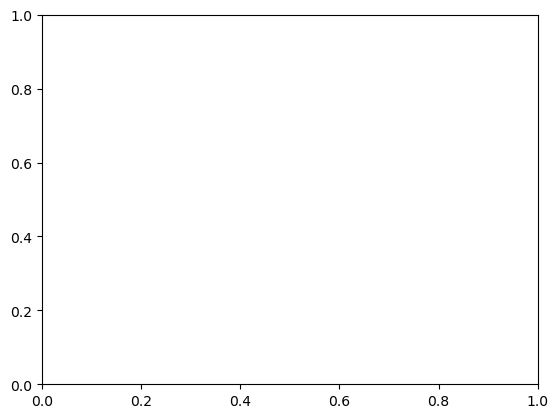

In [9]:
df = pd.read_csv('MINERvA_Neutrino_fluxes.csv')
df2 = pd.read_csv('ND flux data.csv')

# Process MINERvA
df = df[['Bin center', 'Flux', 'Error']].copy()
df['bin center'] = df['Bin center']
bin_centers = df['Bin center'].values
bin_edges = compute_bin_edges(bin_centers)
bin_widths = np.diff(bin_edges)
df['bin width'] = bin_widths
df['flux density'] = df['Flux'] / df['bin width']
df['norm flux'] = df['flux density'] / (df['flux density'] * df['bin width']).sum()
df['error density'] = df['Error'] / df['bin width']
df['norm error'] = df['error density'] / (df['flux density'] * df['bin width']).sum()

# Process ND
df2['bin width'] = df2['emax'] - df2['#emin']
# Step 1: flux density
df2['flux density'] = df2['norm flux'] / df2['bin width']

# Step 2: normalization constant (before overwriting)
norm_factor_nd = (df2['flux density'] * df2['bin width']).sum()

# Step 3: normalize flux
df2['norm flux'] = df2['flux density'] / norm_factor_nd

# Step 4: normalize error the same way
df2['error density'] = df2['fe'] / df2['bin width']
df2['norm error'] = df2['error density'] / norm_factor_nd


# Pion energy sampling
params = np.array([0.49, 0.99, 8.95, 1.02, 14.89, 2.8, 30, 0.1])
samples = 1000000
pions = sample_pion_energy(params, samples)

# Build pion slices & decay populations
scan_min, scan_max, slice_width = 0.0, 30.0, 0.02
pion_slices = build_pion_slices(params, scan_min, scan_max, slice_width)
time_window, time_inc = 10000, 1
time_steps = np.arange(0, time_window + time_inc, time_inc)
decay_pop = compute_decay_population(pion_slices, time_steps)

# Compute speeds (beta*0.3 m/ns)
gamma_vals = pion_slices[:, 1]
beta = np.sqrt(np.clip(1 - 1 / (gamma_vals**2), 0, None))
speeds = 0.3 * beta

# Rebin events to distance
dist_ev, _, _ = rebin_time_to_distance(decay_pop, speeds, dt=1, dd=1)

# Detector geometry
#dets = np.array([[902, 13.07], [900, 15.6], [908, 13.6], [908, 15.6]])

num_det_slices = 10
min_det_y = 12.9 # set as 12.6 plus 30cm buffer
max_det_y = 16.3 # set as 16.6 plus 30cm buffer
det_width = (max_det_y-min_det_y)/num_det_slices

x_dets = np.full(num_det_slices, 992) #sets the x coords of detector slices 
y_dets = np.linspace(min_det_y+det_width/2, max_det_y-det_width/2, num_det_slices) #sets the y coords of detector slice mids 

dets = np.column_stack((x_dets, y_dets))
# l_opps = np.array([12.0, 14.0, 16.0])
l_adj = 1000.0
dd = 1.0

# Off-axis ND prediction
decay_max_distance = 700.0
dist_cutoff_bin = int(decay_max_distance // dd)
dist_ev = dist_ev[:, :dist_cutoff_bin]
nu_e_all, flux_all, solid_angle = compute_flux_matrix(
    dets=dets,
    pion_slices=pion_slices,
    dist_events=dist_ev,
    dd=dd,
    det_width=det_width,     
    det_height=4.0
)


# Apply energy smearing
sigma_E = 0.1
nu_e_all_smeared = apply_energy_smearing(nu_e_all, sigma_E)

e_min = 0
e_max = 20
fine_bins = 500
fine_edges = np.linspace(e_min, e_max, fine_bins + 1)
fine_centers = 0.5 * (fine_edges[:-1] + fine_edges[1:])
bin_width = fine_edges[1] - fine_edges[0]




plt.plot(fine_centers,nu_e_all_smeared)
plt.plot(fine_centers,nu_e_all)
plt.show()

# Plot cumulative flux vs decay distance
#plot_cumulative_flux(flux_all, dd=dd)

# Plot solid angle heatmap
#plot_solid_angle_heatmap(solid_angle_avg, pion_slices, l_opps, l_adj)


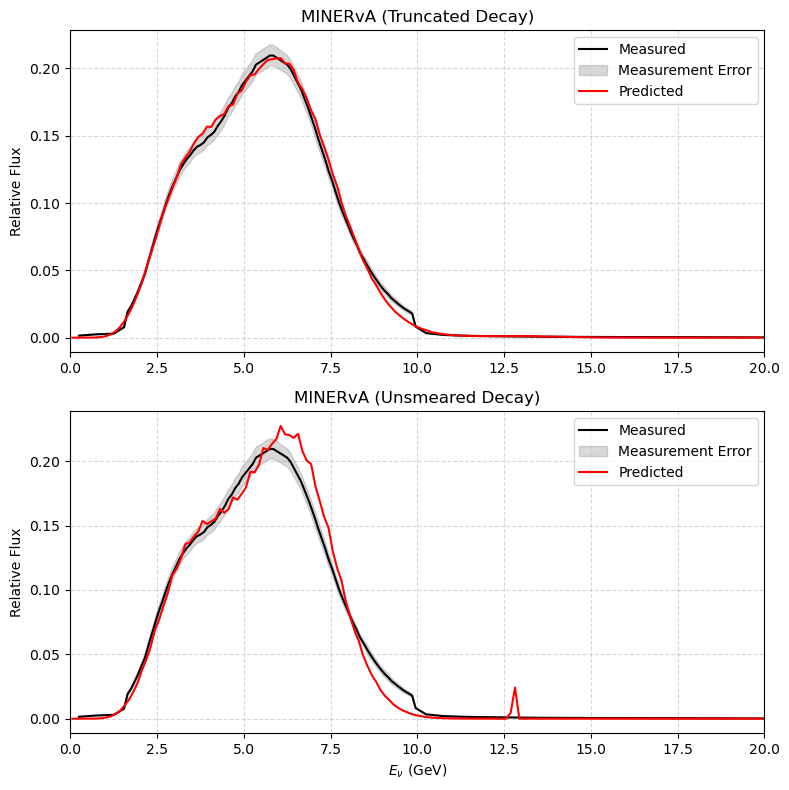

In [259]:
df = pd.read_csv('MINERvA_Neutrino_fluxes.csv')
df2 = pd.read_csv('ND flux data.csv')

df = df[['Bin center', 'Flux', 'Error']].copy()
df['bin center'] = df['Bin center']
bin_centers = df['Bin center'].values
bin_edges = compute_bin_edges(bin_centers)
bin_widths = np.diff(bin_edges)
df['bin width'] = bin_widths
df['flux density'] = df['Flux'] / df['bin width']
df['norm flux'] = df['flux density'] / (df['flux density'] * df['bin width']).sum()
df['error density'] = df['Error'] / df['bin width']
df['norm error'] = df['error density'] / (df['flux density'] * df['bin width']).sum()

dd=1
l_adj = 1000

params = np.array([0.49, 0.99, 8.95, 1.02, 14.89, 2.8, 30, 0.1])
samples = 1000000
pions = sample_pion_energy(params, samples)

# Build pion slices & decay populations
scan_min, scan_max, slice_width = 0.0, 30.0, 0.01
pion_slices = build_pion_slices(params, scan_min, scan_max, slice_width)
time_window, time_inc = 10000, 1
time_steps = np.arange(0, time_window + time_inc, time_inc)
decay_pop = compute_decay_population(pion_slices, time_steps)

# Compute speeds (beta*0.3 m/ns)
gamma_vals = pion_slices[:, 1]
beta = np.sqrt(np.clip(1 - 1 / (gamma_vals**2), 0, None))
speeds = 0.3 * beta

# Rebin events to distance
dist_ev, _, _ = rebin_time_to_distance(decay_pop, speeds, dt=1, dd=1)

# MINERvA truncated
decay_max_distance = 800.0
dist_cutoff_bin = int(decay_max_distance // dd)
dist_ev_miner = dist_ev[:, :dist_cutoff_bin]
nu_miner, flux_miner = compute_flux_matrix_onaxis(pion_slices, dist_ev_miner, l_adj, dd)

# MINERvA full
nu_miner_full, flux_miner_full = compute_flux_matrix_onaxis(pion_slices, dist_ev, l_adj, dd)

# Apply energy smearing
sigma_E = 0.1

nu_miner_smeared = apply_energy_smearing(nu_miner, sigma_E)
nu_miner_full_smeared = apply_energy_smearing(nu_miner_full, sigma_E)


# Plot predicted spectra
fc, hist = plot_neutrino_spectrum(
    fluxes=[ flux_miner, flux_miner],
    labels=[ 'MINERvA Truncated', 'MINERvA Full'],
    nu_energies=[ nu_miner_smeared, nu_miner],
    dataframes=[ df, df],
    titles=[ 'MINERvA (Truncated Decay)', 'MINERvA (Unsmeared Decay)'],
    xlims=[ (0, 20), (0, 20)],
    fine_bins=160
)

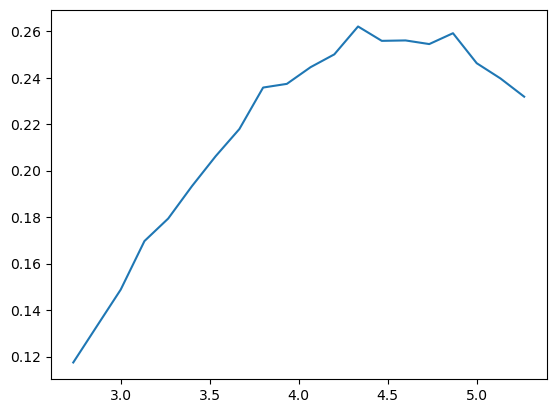

In [217]:
start = 20
stop = 40

plt.plot(fc[start:stop],hist[start:stop])


In [219]:
hist[start:stop]


array([0.11743763, 0.13314947, 0.14881238, 0.16969951, 0.17938532,
       0.19331347, 0.20621763, 0.21791543, 0.23576894, 0.23735124,
       0.24454114, 0.25004982, 0.26205346, 0.25586548, 0.25604677,
       0.25448154, 0.25915354, 0.24624397, 0.23969053, 0.23183683])

In [247]:

def loss_function(params, df_data, pion_config, detector_config):
    """
    Compute loss between predicted and observed neutrino flux.
    """
    # Unpack configs
    scan_min, scan_max, slice_width = pion_config
    l_adj, l_opps, decay_max_distance, dd = detector_config

    # Build pion slices
    pion_slices = build_pion_slices(params, scan_min, scan_max, slice_width)

    # Compute decay populations
    time_window, time_inc = 10000, 1
    time_steps = np.arange(0, time_window + time_inc, time_inc)
    decay_pop = compute_decay_population(pion_slices, time_steps)

    # Compute speeds
    gamma_vals = pion_slices[:, 1]
    beta = np.sqrt(np.clip(1 - 1 / (gamma_vals**2), 0, None))
    speeds = 0.3 * beta

    # Rebin to distance
    dist_ev, _, _ = rebin_time_to_distance(decay_pop, speeds, dt=1, dd=dd)

    # Apply MINERvA decay cutoff
    dist_cutoff_bin = int(decay_max_distance // dd)
    dist_ev = dist_ev[:, :dist_cutoff_bin]

    # Get flux
    nu_pred, flux_pred = compute_flux_matrix_onaxis(pion_slices, dist_ev, l_adj, dd)

    # Apply smearing
    nu_pred_smeared = apply_energy_smearing(nu_pred, frac_sigma=0.1)

    # Histogram prediction
    pred_e = nu_pred_smeared.flatten()
    pred_w = flux_pred.flatten()
    pred_w /= np.sum(pred_w)

    # Get bin edges from data
    centers = df_data['bin center'].values
    edges = compute_bin_edges(centers)

    # Histogram
    hist_pred, _ = np.histogram(pred_e, bins=edges, weights=pred_w, density=True)

    # Match to observed flux
    flux_obs = df_data['norm flux'].values
    error = df_data['norm error'].values if 'norm error' in df_data else np.ones_like(flux_obs)

    # Compute MSE or chi-squared
    chi2 = np.sum(((hist_pred - flux_obs) / error)**2)
    return chi2

In [249]:
# Initial guess
params0 = [0.45, 0.90, 8.3, 1.1, 13.7, 3.5, 24, 2.0]

# Bounds for stability
bounds = [
    (0.01, 0.99),   # w1
    (0.01, 0.99),   # w2_raw
    (0.5, 20),      # gamma shape
    (0.1, 5.0),     # gamma scale
    (8, 15),        # mu2
    (0.1, 3),      # sigma2
    (15, 30),        # mu3
    (0.1, 4),      # sigma3
]

# Configuration
pion_config = (0.0, 30.0, 0.02)
detector_config = (1000.0, np.array([0.0]), 800.0, 1.0)

result = minimize(
    loss_function,
    params0,
    args=(df, pion_config, detector_config),
    bounds=bounds,
    method='L-BFGS-B',
    options={'disp': True}
)

best_params = result.x
print("Best parameters:", best_params)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  6.99660D+04    |proj g|=  1.17000D+01

At iterate    1    f=  6.32564D+04    |proj g|=  1.15762D+01

At iterate    2    f=  1.47363D+04    |proj g|=  1.17956D+01

At iterate    3    f=  1.09547D+04    |proj g|=  1.19974D+01

At iterate    4    f=  9.36707D+03    |proj g|=  1.18141D+01

At iterate    5    f=  9.01473D+03    |proj g|=  1.17709D+01

At iterate    6    f=  8.94939D+03    |proj g|=  1.17453D+01

At iterate    7    f=  8.75405D+03    |proj g|=  1.17557D+01

At iterate    8    f=  8.38274D+03    |proj g|=  7.61639D+00

At iterate    9    f=  8.34960D+03    |proj g|=  7.60196D+00

At iterate   10    f=  8.32128D+03    |proj g|=  1.19397D+01

At iterate   11    f=  8.31489D+03    |proj g|=  1.19546D+01

At iterate   12    f=  8.30717D+03    |proj g|=  1.19766D+01

At iterate   13    f=  8.3

In [34]:
df2

NameError: name 'df2' is not defined

In [54]:
num_det_slices = 10
min_det_y = 12.9 # set as 12.6 plus 30cm buffer
max_det_y = 16.3 # set as 14.6 plus 30cm buffer
det_width = (max_det_y-min_det_y)/num_det_slices

x_dets = np.full(num_det_slices, 902) #sets the x coords of detector slices 
y_dets = np.linspace(min_det_y+det_width/2, max_det_y-det_width/2, num_det_slices) #sets the y coords of detector slice mids 

dets = np.column_stack((x_dets, y_dets))


In [56]:
dets

array([[902.  ,  13.07],
       [902.  ,  13.41],
       [902.  ,  13.75],
       [902.  ,  14.09],
       [902.  ,  14.43],
       [902.  ,  14.77],
       [902.  ,  15.11],
       [902.  ,  15.45],
       [902.  ,  15.79],
       [902.  ,  16.13]])